In [1]:
import pandas as pd

In [92]:
df=pd.read_csv('full_data_preprocessed.csv',index_col=0)
df

,x,y,action,filename,x_smooth,y_smooth,cosine_sim,speed_delta,y_distortion,x_distortion,acc_x,acc_y,acc_mag,y_diff,x_diff,dist_to_event
324564,849.0,257.0,air,data/ball_data_115.json,848.952381,257.738095,1.000000,27.073973,1.0,1.0,0.0,0.0,0.0,-1.133333,21.200000,12
324565,850.0,251.0,air,data/ball_data_115.json,849.500000,250.000000,0.999389,20.260403,1.0,1.0,0.0,0.0,0.0,-1.442857,27.095238,11
324566,849.0,243.0,air,data/ball_data_115.json,849.928571,242.785714,0.999764,8.037516,1.0,1.0,0.0,0.0,0.0,-1.545238,28.602381,10
324567,850.0,236.0,air,data/ball_data_115.json,850.238095,236.095238,0.999993,-3.653257,1.0,1.0,0.0,0.0,0.0,-1.920635,29.984127,9
324568,851.0,230.0,air,data/ball_data_115.json,850.380952,229.285714,0.987649,-9.071733,1.0,1.0,0.0,0.0,0.0,-2.669048,31.445238,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655760,1024.0,401.0,air,data/ball_data_246.json,1024.000000,401.285714,0.903649,-2.509402,1.0,1.0,0.0,0.0,0.0,5.285714,16.485714,16
655761,1023.0,398.0,air,data/ball_data_246.json,1023.761905,398.285714,0.838279,-4.119038,1.0,1.0,0.0,0.0,0.0,4.380952,12.571429,17
655762,1023.0,396.0,air,data/ball_data_246.json,1022.142857,395.571429,0.783668,-4.479658,1.0,1.0,0.0,0.0,0.0,3.628571,8.990476,18
655763,1021.0,393.0,air,data/ball_data_246.json,1019.857143,393.142857,0.700988,-6.951846,1.0,1.0,0.0,0.0,0.0,2.723810,5.704762,19


In [93]:
df_test=df.copy()

In [94]:
df_test.describe()

,x,y,x_smooth,y_smooth,cosine_sim,speed_delta,y_distortion,x_distortion,acc_x,acc_y,acc_mag,y_diff,x_diff,dist_to_event
count,113673.000000,113673.000000,113673.000000,113673.000000,113673.000000,113673.000000,113673.000000,113673.000000,113673.000000,113673.000000,113673.000000,113673.000000,113673.000000,113673.000000
mean,959.682539,485.675225,959.682537,485.675222,0.727303,0.746670,0.679009,0.805635,-0.000015,0.000021,2.179529,-0.009078,-0.007616,13.302455
std,233.944501,183.400563,232.592685,182.359291,0.560117,104.807256,0.734133,0.592414,3.797795,3.223517,4.479277,84.055429,81.216567,9.711093
min,15.000000,18.000000,-118.809524,-13.476190,-1.000000,-1882.429200,-1.000000,-1.000000,-75.839538,-46.625974,0.000000,-1242.942857,-642.533333,0.000000
25%,805.000000,342.000000,806.000000,342.523810,0.860039,-10.349543,1.000000,1.000000,-0.221645,-0.424820,0.474701,-29.323810,-41.123810,6.000000
50%,964.000000,455.000000,962.904762,455.333333,0.988776,-0.699860,1.000000,1.000000,-0.018470,0.421438,0.770547,1.771429,1.657143,12.000000
75%,1118.000000,611.000000,1117.809524,610.380952,0.998127,8.385172,1.000000,1.000000,0.172583,0.702742,1.955081,31.380952,37.876190,19.000000
max,1903.000000,1064.000000,2034.333333,1159.857143,1.000000,1769.012600,1.000000,1.000000,101.952381,49.367965,105.085893,1706.295238,860.476190,76.000000


In [95]:
import pandas as pd
import numpy as np

def classify_ball_events(df, x_col='x', y_col='y', fps=30, smooth_window=3):
    """
    Detects Hits, Bounces, and In-Air states from 2D ball tracking data.
    
    Args:
        df: DataFrame containing the track.
        x_col, y_col: Column names for coordinates.
        fps: Frames per second (to calculate real-world physics units).
        smooth_window: Window size for smoothing noise (odd number).
    
    Returns:
        df: The original DataFrame with added kinematic columns and an 'event_type' label.
    """
    # 1. PREPROCESSING: Smooth the data to reduce tracking noise
    # We use a rolling mean, but Savitzky-Golay is better for production
    df = df.copy()
    df[f'{x_col}_smooth'] = df[x_col].rolling(window=smooth_window, center=True).mean().fillna(df[x_col])
    df[f'{y_col}_smooth'] = df[y_col].rolling(window=smooth_window, center=True).mean().fillna(df[y_col])

    # Time delta (dt)
    dt = 1 / fps

    # 2. KINEMATICS: Calculate Velocity and Acceleration
    # Velocity (First Derivative)
    df['vx'] = np.gradient(df[f'{x_col}_smooth'], dt)
    df['vy'] = np.gradient(df[f'{y_col}_smooth'], dt)
    df['speed'] = np.sqrt(df['vx']**2 + df['vy']**2)

    # Acceleration (Second Derivative)
    df['ax'] = np.gradient(df['vx'], dt)
    df['ay'] = np.gradient(df['vy'], dt)
    df['acc_mag'] = np.sqrt(df['ax']**2 + df['ay']**2)

    # Jerk (Third Derivative - The "Shock" detector)
    # High jerk indicates a sudden physical event (collision)
    df['jerk_mag'] = np.gradient(df['acc_mag'], dt)

    # 3. CURVATURE: Calculate Turning Angle (0 to 180 degrees)
    # A generic "straight" flight has angle ~0. A hit has angle > 0.
    # We use dot product of normalized velocity vectors
    vx_norm = df['vx'] / (df['speed'] + 1e-6) # Avoid div/0
    vy_norm = df['vy'] / (df['speed'] + 1e-6)
    
    # Calculate dot product between vector t and t-1
    # We shift the normalized vectors by 1 frame to compare t vs t-1
    dot_product = (vx_norm * vx_norm.shift(1)) + (vy_norm * vy_norm.shift(1))
    # Clip to valid range for arccos [-1, 1]
    dot_product = dot_product.clip(-1.0, 1.0)
    df['turn_angle_deg'] = np.degrees(np.arccos(dot_product)).fillna(0)
    
    
    return df



In [96]:

# # --- EXAMPLE USAGE ---

# # 1. Create dummy data (A ball travels, bounces, then gets hit)
# t = np.linspace(0, 2, 60)
# x = np.linspace(0, 100, 60) # Moves right
# y = np.concatenate([
#     np.linspace(50, 50, 20),      # Straight line
#     np.linspace(50, 40, 5),       # Slows down (Bounce friction simulation)
#     np.linspace(40, 100, 35)      # Shot up (Hit)
# ]) 
# # Add some noise
# x += np.random.normal(0, 0.5, 60)
# y += np.random.normal(0, 0.5, 60)

# df_ball = pd.DataFrame({'x': x, 'y': y})

# 2. Run detector
results = classify_ball_events(df_test, fps=30)


In [97]:
results

,x,y,action,filename,x_smooth,y_smooth,cosine_sim,speed_delta,y_distortion,x_distortion,...,y_diff,x_diff,dist_to_event,vx,vy,speed,ax,ay,jerk_mag,turn_angle_deg
324564,849.0,257.0,air,data/ball_data_115.json,849.000000,257.000000,1.000000,27.073973,1.0,1.0,...,-1.133333,21.200000,12,10.0,-200.0,200.249844,-5.115908e-11,-1.500000e+02,0.000000,0.000000
324565,850.0,251.0,air,data/ball_data_115.json,849.333333,250.333333,0.999389,20.260403,1.0,1.0,...,-1.442857,27.095238,11,10.0,-205.0,205.243758,-2.557954e-11,-1.500000e+02,-1125.000000,0.070166
324566,849.0,243.0,air,data/ball_data_115.json,849.666667,243.333333,0.999764,8.037516,1.0,1.0,...,-1.545238,28.602381,10,10.0,-210.0,210.237960,7.500000e+01,-6.394885e-12,4500.000000,0.066866
324567,850.0,236.0,air,data/ball_data_115.json,850.000000,236.333333,0.999993,-3.653257,1.0,1.0,...,-1.920635,29.984127,9,15.0,-205.0,205.548048,0.000000e+00,4.500000e+02,13884.372072,1.458627
324568,851.0,230.0,air,data/ball_data_115.json,850.666667,229.666667,0.987649,-9.071733,1.0,1.0,...,-2.669048,31.445238,8,10.0,-180.0,180.277564,-2.250000e+02,9.750000e+02,6936.215693,1.005120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655760,1024.0,401.0,air,data/ball_data_246.json,1024.000000,401.333333,0.903649,-2.509402,1.0,1.0,...,5.285714,16.485714,16,-20.0,-95.0,97.082439,2.557954e-11,3.000000e+02,4056.245185,1.503882
655761,1023.0,398.0,air,data/ball_data_246.json,1023.333333,398.333333,0.838279,-4.119038,1.0,1.0,...,4.380952,12.571429,17,-25.0,-85.0,88.600226,-4.500000e+02,3.000000e+02,11607.548696,4.500898
655762,1023.0,396.0,air,data/ball_data_246.json,1022.333333,395.666667,0.783668,-4.479658,1.0,1.0,...,3.628571,8.990476,18,-50.0,-75.0,90.138782,-1.050000e+03,2.250000e+02,7677.637084,17.300531
655763,1021.0,393.0,air,data/ball_data_246.json,1020.000000,393.333333,0.700988,-6.951846,1.0,1.0,...,2.723810,5.704762,19,-95.0,-70.0,118.004237,-1.050000e+03,7.500000e+01,-4857.548696,19.925584


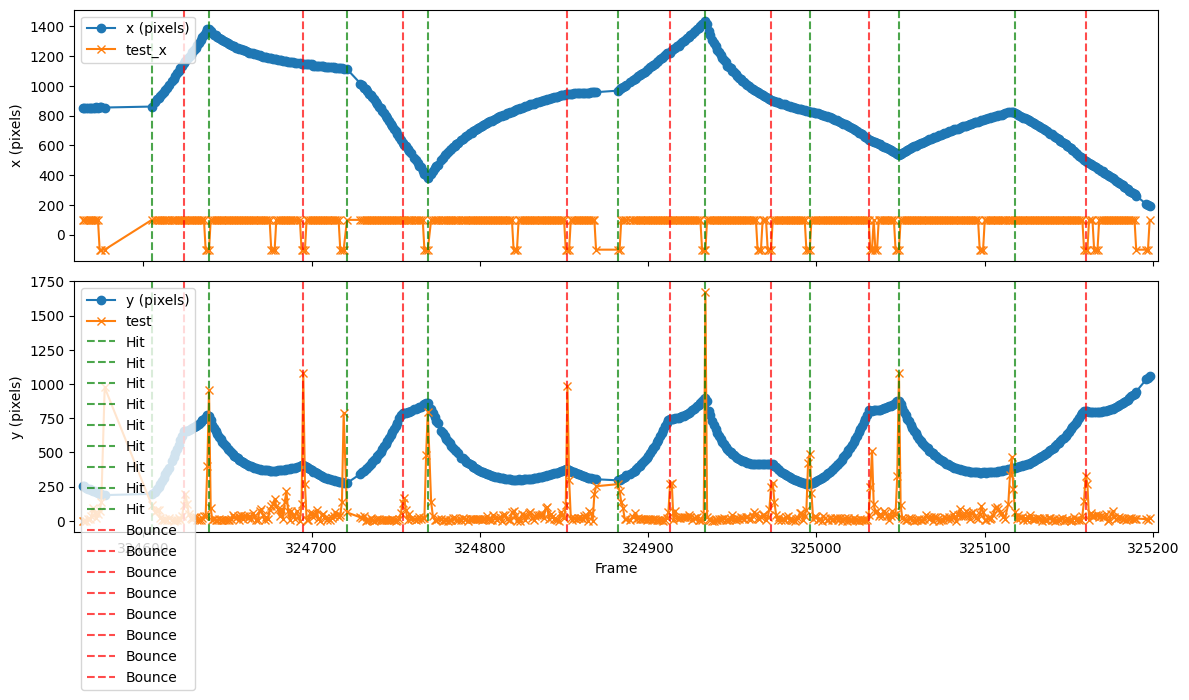

In [42]:
from to_plot import plot_ball_timeseries

plot_ball_timeseries(115,results['turn_angle_deg']*10,results['y_distortion']*100)

In [98]:
model_df=results.drop(columns=['action','x','y','filename','x_smooth','y_smooth'])

In [99]:
model_df.columns

Index(['cosine_sim', 'speed_delta', 'y_distortion', 'x_distortion', 'acc_x',
       'acc_y', 'acc_mag', 'y_diff', 'x_diff', 'dist_to_event', 'vx', 'vy',
       'speed', 'ax', 'ay', 'jerk_mag', 'turn_angle_deg'],
      dtype='object')

In [100]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns


scaler = StandardScaler()
X_scaled = scaler.fit_transform(model_df)

# Fit K-Means
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
results['cluster'] = kmeans.fit_predict(X_scaled)


In [101]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create the contingency table
# Rows = Actual Actions (Ground Truth)
# Columns = Predicted Clusters (0, 1, 2)
crosstab = pd.crosstab(results['action'], results['cluster'])

print("--- Confusion Matrix (Counts) ---")
print(crosstab)

--- Confusion Matrix (Counts) ---
cluster      0      1     2
action                     
air      13729  95528  1370
bounce     671    728    47
hit       1112    406    82


In [59]:
# Assuming you assigned 'cluster' to model_df
cluster_profiles = results.groupby('cluster')[['acc_mag', 'jerk_mag', 'speed', 'turn_angle_deg']].mean()
print(cluster_profiles)

              acc_mag      jerk_mag        speed  turn_angle_deg
cluster                                                         
0         7688.088861  16162.078272   335.153350       39.248190
1         1032.073370   -509.187965   385.459923        3.125141
2        10904.017768  12061.642978  1011.092538        1.414031


In [60]:
centroids = kmeans.cluster_centers_

In [80]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

# --- ASSUMING the following variables are defined from previous steps:
# X_scaled: The scaled feature matrix (numpy array)
# kmeans: The fitted KMeans object
# model_df: The DataFrame containing the features and 'cluster' column

centroids = kmeans.cluster_centers_

# 1. Calculate distances from every point to ALL centroids
distances = cdist(X_scaled, centroids, 'euclidean')

# 2. Get the distance to the ASSIGNED centroid for each point
distances_to_own_centroid = distances[np.arange(len(distances)), kmeans.labels_]
model_df['distance_to_centroid'] = distances_to_own_centroid

# 3. Define outliers using IQR for each cluster
outliers = pd.Series(False, index=results.index)

for k in range(kmeans.n_clusters):
    cluster_data = results[results['cluster'] == k]
    
    # Use the .quantile() method to find Q1 and Q3
    Q1 = cluster_data['distance_to_centroid'].quantile(0.25)
    Q3 = cluster_data['distance_to_centroid'].quantile(0.75)
    
    IQR = Q3 - Q1
    
    # Define outlier threshold: Q3 + 1.5 * IQR
    # (Only check the upper bound since distance must be > 0)
    outlier_threshold_iqr = Q3 + 1.5 * IQR
    
    # Mark points in this cluster that exceed the threshold
    # Note: Using .loc[cluster_data.index] ensures proper alignment
    cluster_outliers = (cluster_data['distance_to_centroid'] > outlier_threshold_iqr)
    
    # Update the master 'outliers' Series
    outliers.loc[cluster_outliers.index] = cluster_outliers # Assign the boolean result
    
# 4. Final Assignment
results['is_outlier'] = outliers

In [84]:
results[results['is_outlier']==True]

,x,y,action,filename,x_smooth,y_smooth,cosine_sim,speed_delta,y_distortion,x_distortion,...,vy,speed,ax,ay,jerk_mag,turn_angle_deg,event_type,cluster,distance_to_centroid,is_outlier
324623,1133.000000,621.000,air,data/ball_data_115.json,1132.868056,621.326389,0.899032,-67.468770,1.0,1.0,...,824.895833,961.000873,-495.31250,-6673.43750,110665.446990,3.331775,In-Air,1,6.170070,True
324717,1119.000000,283.000,air,data/ball_data_115.json,1118.666667,284.000000,-0.137165,108.207410,-1.0,1.0,...,-80.000000,87.321246,-386.71875,178.12500,139359.766504,4.189361,In-Air,1,6.131566,True
324721,1111.843750,276.375,hit,data/ball_data_115.json,1080.614583,299.458333,0.945840,126.854110,1.0,1.0,...,680.000000,1267.793359,-9426.56250,8268.75000,-223660.107498,6.164801,HIT,1,10.754570,True
324729,1015.000000,343.000,air,data/ball_data_115.json,1043.614583,324.458333,0.972556,-18.592491,1.0,1.0,...,823.125000,1438.086098,3911.71875,-1003.12500,23210.724187,2.479503,In-Air,1,6.943651,True
324730,1004.000000,354.000,air,data/ball_data_115.json,1002.000000,354.333333,0.991194,-67.939125,1.0,1.0,...,613.125000,1015.262159,11988.28125,-7396.87500,52002.457621,2.234279,BOUNCE,1,9.856958,True
324731,987.000000,366.000,air,data/ball_data_115.json,989.666667,365.333333,0.988774,-88.726080,1.0,1.0,...,330.000000,503.289181,6288.28125,-4096.87500,-203186.694665,3.821431,BOUNCE,1,7.093355,True
324772,426.000000,790.000,air,data/ball_data_115.json,427.000000,788.333333,0.944743,84.248055,1.0,1.0,...,-948.072917,1108.624426,230.46875,1171.09375,-112913.589364,3.846888,In-Air,1,6.374377,True
324934,1433.458333,901.375,hit,data/ball_data_115.json,1424.819444,889.458333,-0.994611,158.814740,-1.0,-1.0,...,-455.000000,536.889188,-13793.75000,-18581.25000,21873.714890,166.990501,HIT,0,14.978430,True
324936,1366.000000,805.000,air,data/ball_data_115.json,1374.666667,818.000000,0.997462,96.888214,1.0,1.0,...,-1356.875000,1683.953810,-2740.62500,-2671.87500,-173973.995914,1.252615,In-Air,1,9.426515,True
324937,1341.000000,774.000,air,data/ball_data_115.json,1339.000000,770.000000,0.999566,13.624817,1.0,1.0,...,-1250.000000,1561.001281,3259.37500,4603.12500,21337.137187,0.480925,In-Air,1,8.128237,True


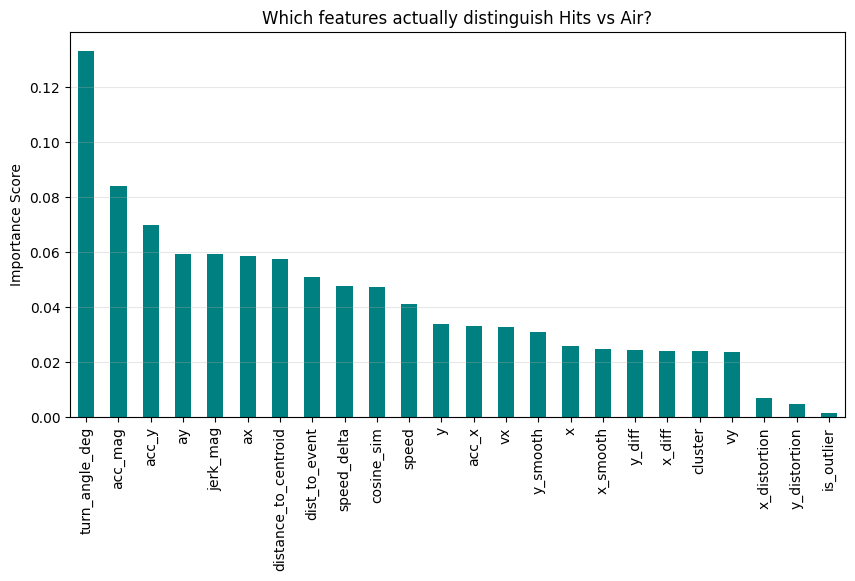

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 1. Train a quick model
model = RandomForestClassifier(n_estimators=50, random_state=42)
y = results['action']

model.fit(results.drop(columns=['action','filename','event_type']), y)

# 2. Get Importance
importances = pd.Series(model.feature_importances_, index=results.drop(columns=['action','filename','event_type']).columns).sort_values(ascending=False)

# 3. Plot
plt.figure(figsize=(10, 5))
importances.plot(kind='bar', color='teal')
plt.title("Which features actually distinguish Hits vs Air?")
plt.ylabel("Importance Score")
plt.grid(axis='y', alpha=0.3)
plt.show()

In [123]:
model_df=results.drop(columns=['action','x','y','filename','x_smooth','y_smooth'])

In [132]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
# 2. Initialize and Train the Isolation Forest Model

scaler = StandardScaler()
X = scaler.fit_transform(model_df)
# The 'contamination' parameter is crucial in unsupervised methods.
# It is an estimate of the proportion of outliers in the dataset.
# If you have no idea, a small value like 'auto' or 0.01 is often used.
# Here, we know we have 4 anomalies out of 1000, so 4/1000 = 0.004.
model = IsolationForest(
    n_estimators=1000,             # Number of trees in the forest
    contamination=0.05,          # Estimated proportion of outliers (0.5%)
    max_features=X.shape[1],   # Use all features
    random_state=42,
    n_jobs=-1                     # Use all processors
)

# Fit the model to your data. This is the unsupervised training step.
model.fit(X)

,"n_estimators n_estimators: int, default=100The number of base estimators in the ensemble.",1000
,"max_samples max_samples: ""auto"", int or float, default=""auto""The number of samples to draw from X to train each base estimator.- If int, then draw `max_samples` samples.- If float, then draw `max_samples * X.shape[0]` samples.- If ""auto"", then `max_samples=min(256, n_samples)`.If max_samples is larger than the number of samples provided,all samples will be used for all trees (no sampling).",'auto'
,"contamination contamination: 'auto' or float, default='auto'The amount of contamination of the data set, i.e. the proportionof outliers in the data set. Used when fitting to define the thresholdon the scores of the samples.- If 'auto', the threshold is determined as in the original paper.- If float, the contamination should be in the range (0, 0.5]... versionchanged:: 0.22 The default value of ``contamination`` changed from 0.1 to ``'auto'``.",0.05
,"max_features max_features: int or float, default=1.0The number of features to draw from X to train each base estimator.- If int, then draw `max_features` features.- If float, then draw `max(1, int(max_features * n_features_in_))` features.Note: using a float number less than 1.0 or integer less than number offeatures will enable feature subsampling and leads to a longer runtime.",19
,"bootstrap bootstrap: bool, default=FalseIf True, individual trees are fit on random subsets of the trainingdata sampled with replacement. If False, sampling without replacementis performed.",False
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for :meth:`fit`. ``None`` means 1unless in a :obj:`joblib.parallel_backend` context. ``-1`` means usingall processors. See :term:`Glossary ` for more details.",-1
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseudo-randomness of the selection of the featureand split values for each branching step and each tree in the forest.Pass an int for reproducible results across multiple function calls.See :term:`Glossary `.",42
,"verbose verbose: int, default=0Controls the verbosity of the tree building process.",0
,"warm_start warm_start: bool, default=FalseWhen set to ``True``, reuse the solution of the previous call to fitand add more estimators to the ensemble, otherwise, just fit a wholenew forest. See :term:`the Glossary `... versionadded:: 0.21",False


In [133]:
results['anomaly'] = model.predict(X)

In [134]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create the contingency table
# Rows = Actual Actions (Ground Truth)
# Columns = Predicted Clusters (0, 1, 2)
crosstab = pd.crosstab(results['action'], results['anomaly'])

print("--- Confusion Matrix (Counts) ---")
print(crosstab)

--- Confusion Matrix (Counts) ---
anomaly    -1       1
action               
air      5087  105540
bounce     87    1359
hit       510    1090
